features: (32517, 1)
targets: (32517, 1)
X_train: (23493, 1)
X_test: (4878, 1)
X_val: (4146, 1)
y_train: (23493, 1)
y_test: (4878, 1)
y_val: (4146, 1)
Epoch 1/100
184/184 - 2s - loss: 93.4933 - val_loss: 0.1186 - lr: 0.0100 - 2s/epoch - 11ms/step
Epoch 2/100
184/184 - 0s - loss: 0.1029 - val_loss: 0.0502 - lr: 0.0100 - 389ms/epoch - 2ms/step
Epoch 3/100
184/184 - 0s - loss: 0.0462 - val_loss: 0.0357 - lr: 0.0100 - 369ms/epoch - 2ms/step
Epoch 4/100
184/184 - 0s - loss: 0.0266 - val_loss: 0.0325 - lr: 0.0100 - 355ms/epoch - 2ms/step
Epoch 5/100
184/184 - 0s - loss: 0.0163 - val_loss: 0.0079 - lr: 0.0100 - 360ms/epoch - 2ms/step
Epoch 6/100
184/184 - 0s - loss: 0.0058 - val_loss: 0.0022 - lr: 0.0100 - 370ms/epoch - 2ms/step
Epoch 7/100
184/184 - 0s - loss: 0.0025 - val_loss: 0.0013 - lr: 0.0100 - 357ms/epoch - 2ms/step
Epoch 8/100
184/184 - 0s - loss: 0.0014 - val_loss: 6.8376e-04 - lr: 0.0100 - 360ms/epoch - 2ms/step
Epoch 9/100
184/184 - 0s - loss: 8.4017e-04 - val_loss: 4.5449e-04 - l

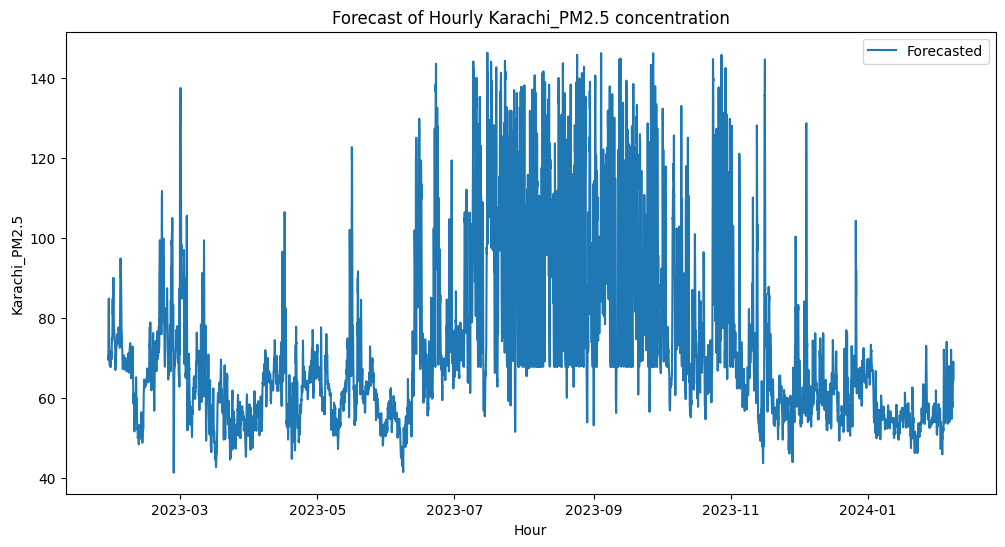

   6/9024 [..............................] - ETA: 3:06:38

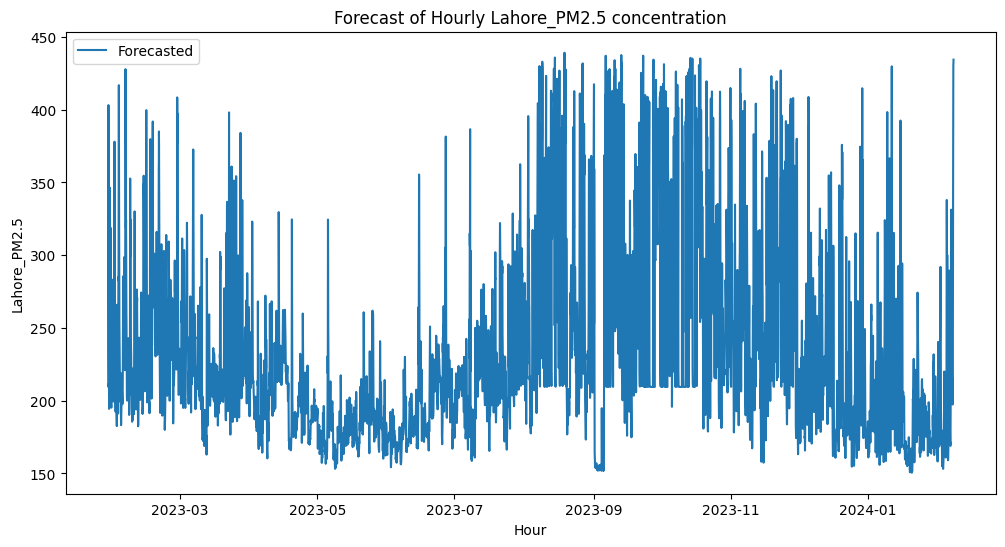

  17/9024 [..............................] - ETA: 3:10:03

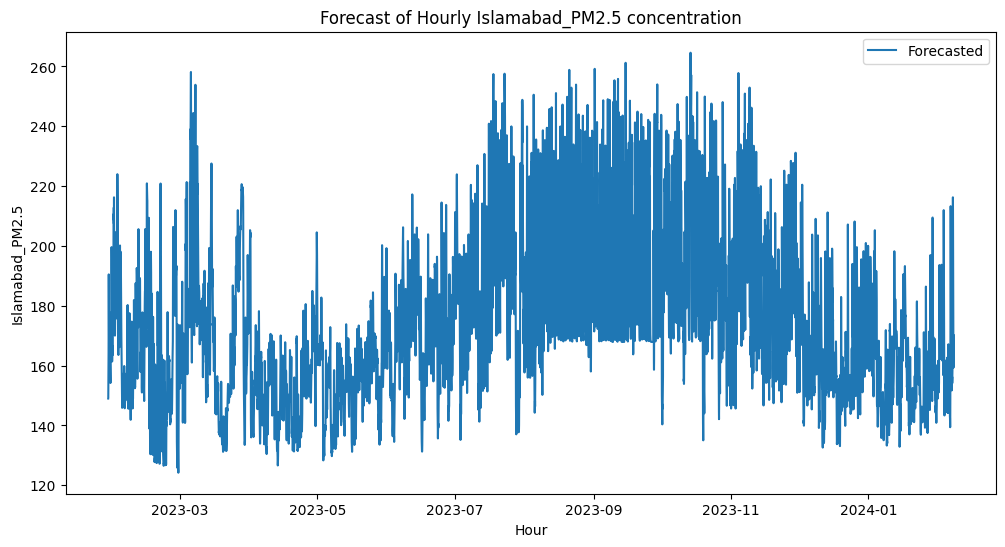

  21/9024 [..............................] - ETA: 3:07:27

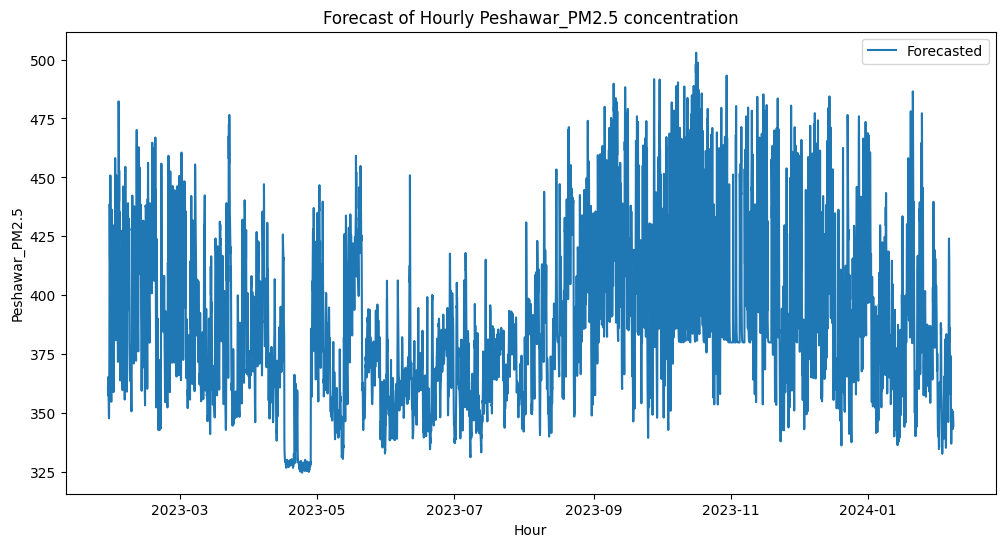

9017/9024 [============================>.] - ETA: 8s 

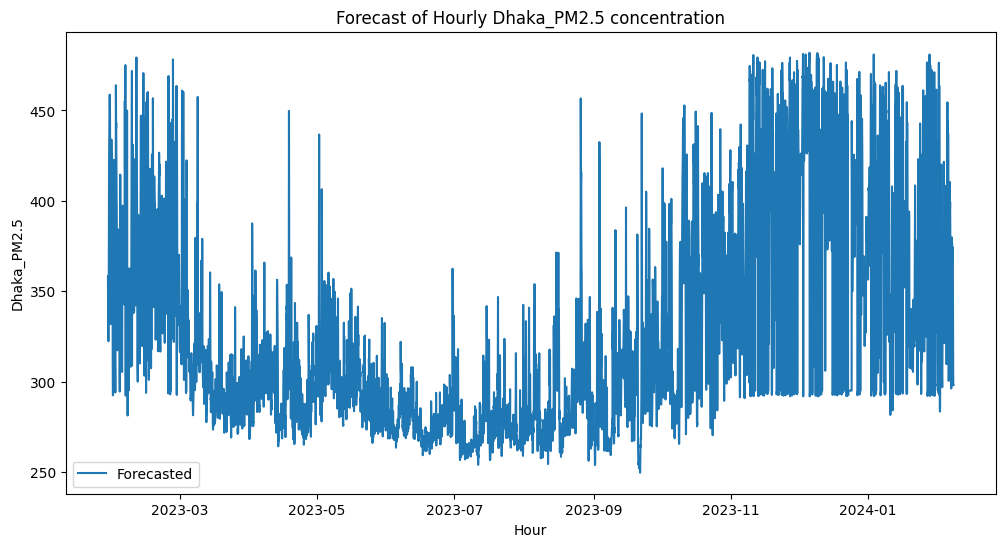

9019/9024 [============================>.] - ETA: 6ss

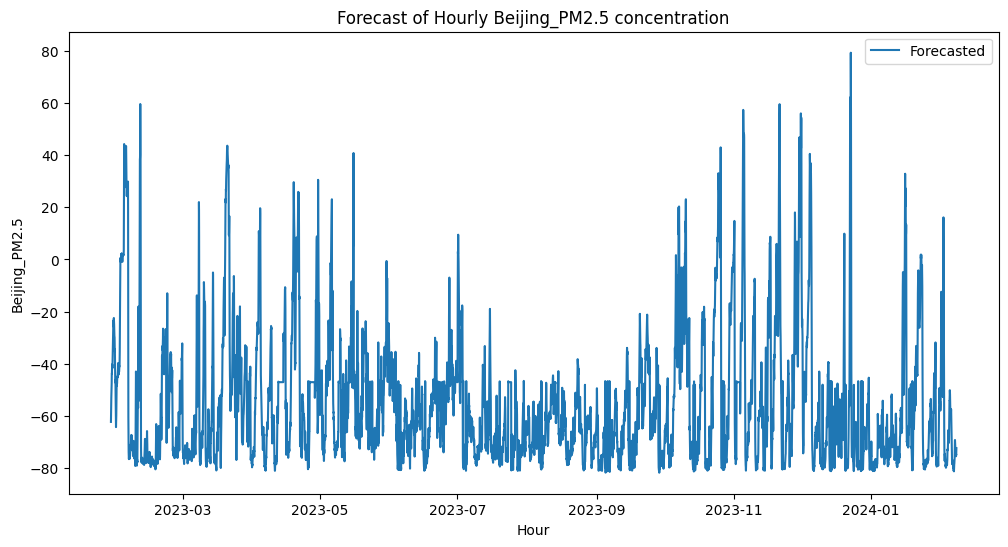

8986/9024 [============================>.] - ETA: 48s2:2

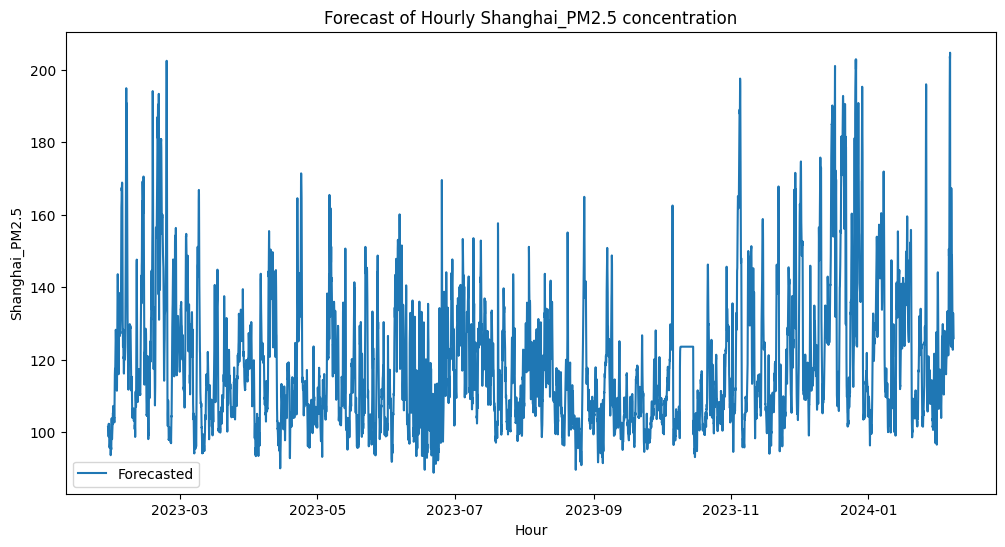

  47/9024 [..............................] - ETA: 3:08:10

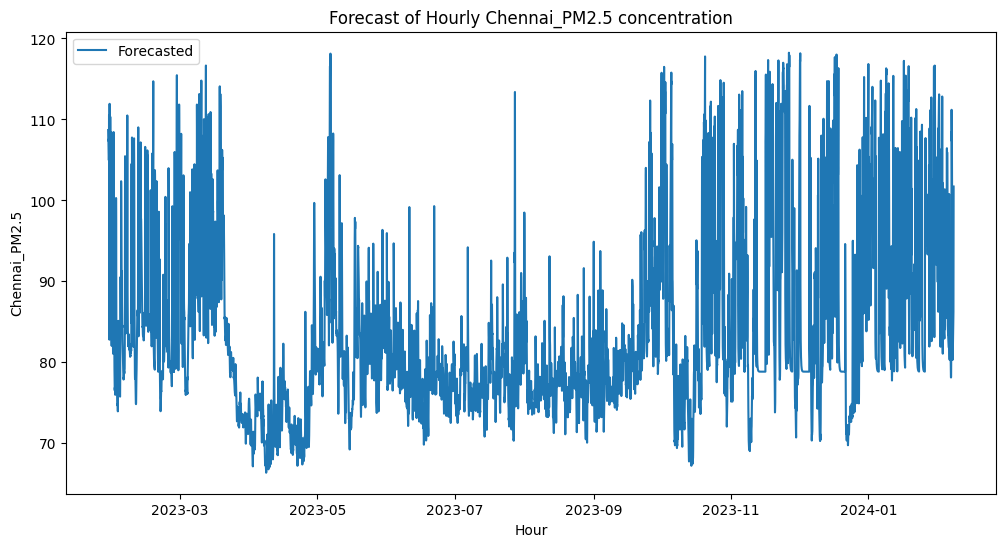

9018/9024 [============================>.] - ETA: 6s

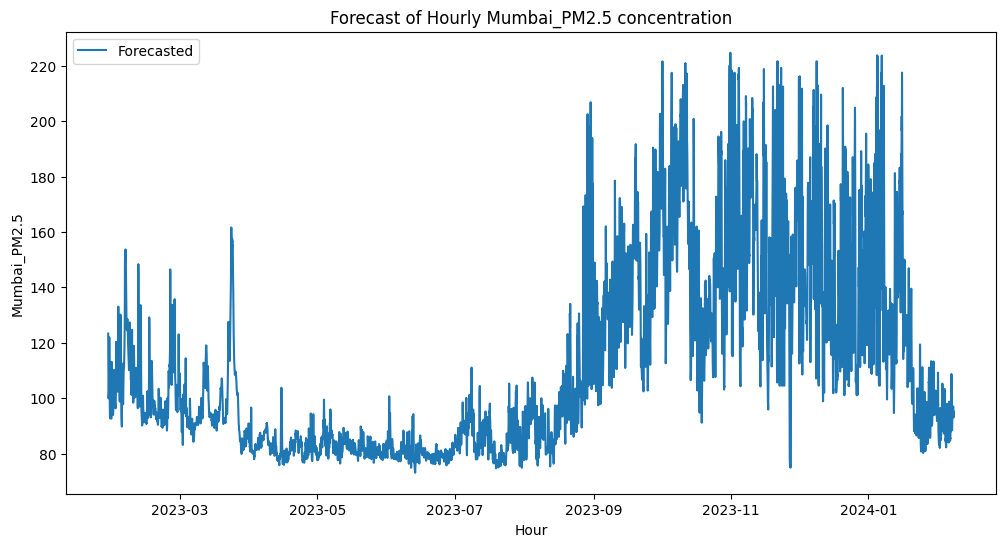

 91/735 [==>...........................] - ETA: 1s

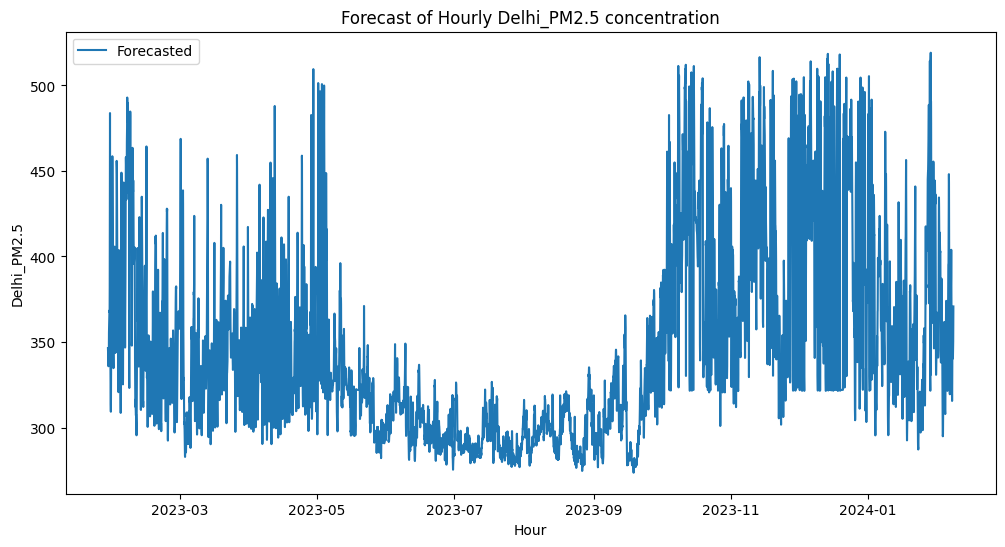

9024/9024 [==============================] - 10202s 1s/step


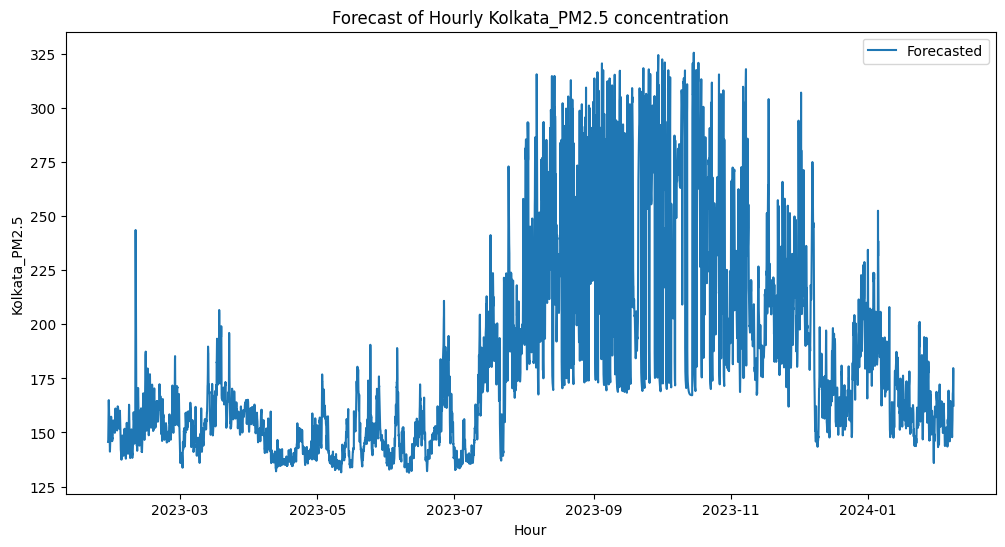

153/153 [==============================] - 0s 1ms/step


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
import pywt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

# Enable GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Find CSV files
files = glob.glob(r'D:\A_NAUSHAD\E\Dataset\Book6.csv')

def wavelet_transform(data, wavelet='db1'):
    coeffs = pywt.wavedec(data, wavelet, mode='periodization')
    return coeffs

def inverse_wavelet_transform(coeffs, wavelet='db1'):
    return pywt.waverec(coeffs, wavelet, mode='periodization')

# Function to evaluate predictions
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)

    return {
        "mae": mae.numpy().mean(),  # Ensure these are scalar values
        "mse": mse.numpy().mean(),  # Ensure these are scalar values
        "rmse": rmse.numpy().mean(),  # Ensure these are scalar values
        "mape": mape.numpy().mean(),  # Ensure these are scalar values
        "mslr": mslr.numpy().mean(),  # Ensure these are scalar values
    }

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(GRU(10, activation='relu', input_shape=input_shape))  # Reduced units
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')  # Increased learning rate
    return model

# Function to save DataFrame to CSV
def save_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

# Function to process and save results
def process_and_save_results(column, df, history, y_test_inverse, y_pred_inverse, model, X_train, feature_transformed):
    # Create DataFrame for forecast
    forecast_dates = pd.date_range(start='2023-01-28', end='2024-12-31', freq='H')
    df_forecast = pd.DataFrame(index=forecast_dates)
    
    # Forecast values using the model
    feature_scaled = feature_transformed.reshape(-1, 1)
    scaler = MinMaxScaler()
    feature_scaled = scaler.fit_transform(feature_scaled)

    forecast_generator = TimeseriesGenerator(feature_scaled, np.zeros(len(feature_scaled)), length=len(X_train), sampling_rate=1, batch_size=1)
    predicted_values_forecast = model.predict(forecast_generator)
    predicted_values_forecast = scaler.inverse_transform(predicted_values_forecast)

    # Adjust the length of predicted_values_forecast to match df_forecast
    if len(predicted_values_forecast) > len(df_forecast):
        predicted_values_forecast = predicted_values_forecast[:len(df_forecast)]
    else:
        forecast_values = np.full((len(df_forecast), 1), np.nan)
        forecast_values[:len(predicted_values_forecast)] = predicted_values_forecast
        predicted_values_forecast = forecast_values

    df_forecast[column] = predicted_values_forecast

    # Save forecasted values to CSV
    df_forecast.to_csv(f'D:/A_NAUSHAD/E/RESULTS/FORE/train_GRU_{column}_Wave_fore.csv')

    # Plot the forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(df_forecast.index, df_forecast[column], label='Forecasted')
    plt.xlabel('Hour')
    plt.ylabel(column)
    plt.legend()
    plt.title(f'Forecast of Hourly {column} concentration')
    plt.show()
    
    pd.DataFrame(history.history['loss']).to_csv(f'D:/A_NAUSHAD/E/RESULTS/LOSS/train_GRU_{column}_Wave_loss.csv')
    pd.DataFrame(history.history['val_loss']).to_csv(f'D:/A_NAUSHAD/E/RESULTS/LOSS/val_GRU_{column}_Wave_loss.csv')

    # Save predictions to CSV
    predictions_train = model.predict(X_train)
    pd.DataFrame(predictions_train).to_csv(f'D:/A_NAUSHAD/E/RESULTS/PRED/train_GRU_{column}_Wave_pred.csv')
    predictions_test = model.predict(X_test)
    pd.DataFrame(predictions_test).to_csv(f'D:/A_NAUSHAD/E/RESULTS/PRED/test_GRU_{column}_Wave_pred.csv')

    # Evaluate and save predictions
    eval_results = evaluate_preds(y_true=y_test_inverse, y_pred=y_pred_inverse)
    eval_df = pd.DataFrame.from_dict(eval_results, orient='index', columns=['value'])
    eval_df.to_csv(f'D:/A_NAUSHAD/E/RESULTS/EVAL/test_{column}_GRU_Wave_eval.csv')
    

# Loop over files
for file in files:
    df = pd.read_csv(file, parse_dates=['Date'], index_col=['Date'])

    # Create a ThreadPoolExecutor for parallel file operations
    with ThreadPoolExecutor(max_workers=4) as executor:
        # List of tasks to execute
        tasks = []

        for column in df.columns:
            feature = df[[column]].values
            target = df[[column]].values

            # Apply wavelet transformation
            feature_wavelet = wavelet_transform(feature)
            target_wavelet = wavelet_transform(target)

            # Choose the approximation coefficients (low frequency components) for training
            feature_transformed = feature_wavelet[0]
            target_transformed = target_wavelet[0]

            # Data Splitting
            X_train, X_test, y_train, y_test = train_test_split(feature_transformed, target_transformed, test_size=0.15, random_state=1, shuffle=False)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1, shuffle=False)
            
            print("features:", feature.shape)
            print("targets:", target.shape)

            print("X_train:", X_train.shape)
            print("X_test:", X_test.shape)
            print("X_val:", X_val.shape)

            print("y_train:", y_train.shape)
            print("y_test:", y_test.shape)
            print("y_val:", y_val.shape)
            
            # Reshape data for LSTM
            X_train = np.expand_dims(X_train, axis=-1)
            X_val = np.expand_dims(X_val, axis=-1)
            X_test = np.expand_dims(X_test, axis=-1)
            
            # Build LSTM model
            model = create_lstm_model((None, 1))
            
            # Callbacks
            lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, cooldown=1)
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
            
            # Train the model with callbacks
            history = model.fit(
                X_train, y_train, 
                epochs=100,  # Further reduced number of epochs
                validation_data=(X_val, y_val), 
                batch_size=128,  # Increased batch size
                callbacks=[lr_monitor, early_stopping],
                verbose=2  # Reduced verbosity
            )
            
            # Evaluate the model
            loss = model.evaluate(X_test)
            print(f'Test loss for column {column}: {loss}')
            
            # Predict on test set
            y_pred = model.predict(X_test)
            
            # Combine the predicted low-frequency component with the original high-frequency components
            y_test_wavelet = list(target_wavelet)
            y_test_wavelet[0] = y_test  # Replace the low-frequency component with the test set target
            y_pred_wavelet = list(target_wavelet)
            y_pred_wavelet[0] = y_pred.flatten()  # Replace the low-frequency component with the predicted values

            # Inverse wavelet transformation
            y_test_inverse = inverse_wavelet_transform(y_test_wavelet)
            y_pred_inverse = inverse_wavelet_transform(y_pred_wavelet)

            # Submit tasks for processing and saving results
            tasks.append(executor.submit(process_and_save_results, column, df, history, y_test_inverse, y_pred_inverse, model, X_train, feature_transformed))

        # Wait for all tasks to complete
        for task in tasks:
            task.result()  # This will raise exceptions if any occurred during execution
